I'll create a toy dataset for regression. Then I'll test two different neural network settings. 1) I'll train an ensemble of neural networks without any additional regularization etc. 2) I'll train an ensemble where each ensemble member is trained using the diversity objective forcing it's output to be ``bad'' for inputs that are away from the training inputs.

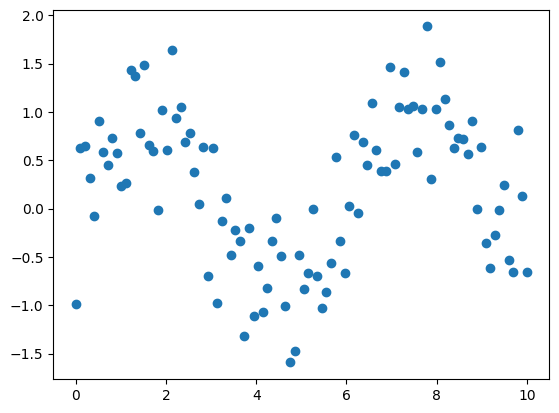

In [14]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
from jax import random

key = random.PRNGKey(0)
std = 0.5
start = 0
end = 10
sampling = 100


x = jnp.linspace(start,end,sampling)
y = jnp.sin(x)+std*random.normal(key=key,shape=x.shape)

plt.scatter(x,y)

Create a training, testing and unlabeled dataset.

In [15]:
x_training = x[jnp.where(jnp.logical_or(x>6,x<2))]
y_training = y[jnp.where(jnp.logical_or(x>6,x<2))]

x_test = x[jnp.where(jnp.logical_and(x<6,x>2))]
y_test = y[jnp.where(jnp.logical_and(x<6,x>2))]


std = 0.5
start = 0
end = 10
sampling = 100

key, new_key = random.split(key)
x_unlabeled = jnp.linspace(start,end,sampling)
y_unlabeled = jnp.sin(x)+std*random.normal(key=new_key,shape=x.shape)

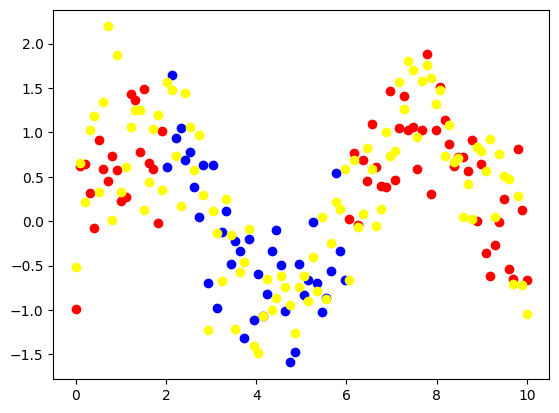

In [16]:
plt.figure()
plt.scatter(x_training,y_training,c='red')
plt.scatter(x_test,y_test,c='blue')
plt.scatter(x_unlabeled,y_unlabeled,c='yellow')

I'll expand the array dimensions so that they match what's expected at the neural network input and output.

In [17]:
x_training = jnp.expand_dims(x_training,axis=1)
y_training = jnp.expand_dims(y_training,axis=1)


y_test = jnp.expand_dims(y_test,axis=1)
x_test = jnp.expand_dims(x_test,axis=1)

y_unlabeled = jnp.expand_dims(y_unlabeled,axis=1)
x_unlabeled = jnp.expand_dims(x_unlabeled,axis=1)

print(x_training.shape)

(60, 1)


I'll define now the model.

In [18]:
from flax import linen as nn
class MLP(nn.Module):
    """
    A simple MLP model.
    """

    @nn.compact
    def __call__(self, x, train):
        out = nn.Dense(features=100)(x)
        out = nn.relu(out)
        out = nn.Dense(features=100)(out)
        out = nn.relu(out)
        out = nn.Dense(features=100)(out)
        out = nn.relu(out)
        out = nn.Dense(features=1)(out)
        return out

Let's define now some routines which are useful for optimizing the neural network.

In [19]:
from omegaconf import DictConfig
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from typing import Any
import hydra

ModuleDef = Any
KeyArray = random.KeyArray
Array = Any
DTypeLikeFloat = Any
DTypeLikeComplex = Any
DTypeLikeInexact = Any
RealNumeric = Any


def squared_error(*, logits, targets):
    """
    The squared error. Can also be seen as NLL with a Gaussian likelihood.
    Parameters
    ----------
    logits: float
        The prediction preactivations of the neural network.
    targets:
        The regression targets.

    Returns
    -------
        : optax.l2_loss
        The l2 loss.

    """
    return optax.l2_loss(predictions=logits, targets=targets).mean()


def compute_metrics(*, logits, targets):
    """
    Computes the crossentropy loss and the accuracy for a given set of predictions and groundtruth labels.
    Parameters
    ----------
    logits: float
        The prediction preactivations of the neural network.
    labels:
        The groundtruth labels.

    Returns
    -------
    metrics: dict
        A python dictionary with keys "loss" and "accuracy" corresponding to the cross-entropy loss and the accuracy
        for some logits and labels.

    """
    loss = squared_error(logits=logits, targets=targets)
    metrics = {
        'loss': loss
    }
    return metrics


def create_train_state(rng):
    """
    Creates initial `TrainState`.
    Parameters
    ----------
    rng : jax.random.PRNGKey
        Pseudo-random number generator (PRNG) key for the random initialization of the neural network.
    cfg : DictConfig
        The configuration file for the experiment.

    Returns
    -------
        :train_state.TrainState
        The initial training state of the experiment.
    """
    network = MLP()
    params = network.init(rng, jnp.ones([1, 1]), train=False)
    tx = optax.adamw(0.001)
    return train_state.TrainState.create(apply_fn=network.apply, params=params, tx=tx)


@jax.jit
def train_step(state, dropout_rng):
    """
    Trains the neural network for a single step."
    Parameters
    ----------
    state : train_state.TrainState
        The initial training state of the experiment.
    batch : dict
        Dictionary with keys 'image' and 'label' corresponding to a batch of the training set.
    dropout_rng : jax.random.PRNGKey
        Pseudo-random number generator (PRNG) key for the randomness of the dropout layers.

    Returns
    -------
    state : train_state.TrainState
        The training state of the experiment.
    metrics : dict
        A python dictionary with keys "loss" and "accuracy" corresponding to the cross-entropy loss and the accuracy
        for some logits and labels.
    new_dropout_rng : jax.random.PRNGKey
        New pseudo-random number generator (PRNG) key for the randomness of the dropout layers.

    """
    dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

    def loss_fn(params):
        logits = state.apply_fn(params, x_training, train=True, rngs={'dropout': dropout_rng})
        loss = squared_error(logits=logits, targets=y_training)
        return loss, logits
    grad_fn = jax.grad(loss_fn, has_aux=True)
    grads, logits = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, targets=y_training)
    return state, metrics, new_dropout_rng


@jax.jit
def eval_step(state):
    """
    A single evaluation step of the output logits of the neural network for a batch of inputs, as well as the
    cross-entropy loss and the classification accuracy.
    Parameters
    ----------
    state : train_state.TrainState
        The training state of the experiment.
    batch : dict
        Dictionary with keys 'image' and 'label' corresponding to a batch of the training set.

    Returns
    -------
    metrics : dict
        A python dictionary with keys "loss" and "accuracy" corresponding to the cross-entropy loss and the accuracy
        for some logits and labels.
    """
    logits = state.apply_fn(state.params, x_test, train=False)
    return compute_metrics(logits=logits, targets=y_test)


def train_epoch(state, epoch, rng):
    """
    Train for a single epoch.
    Parameters
    ----------
    state : train_state.TrainState
        The training state of the experiment.
    train_ds: dict
        Dictionary with keys 'image' and 'label' corresponding to the training set.
    batch_size : int
        The size of the batch.
    epoch : int
        The number of the current epoch.
    rng : jax.random.PRNGKey
        Pseudo-random number generator (PRNG) key for the random initialization of the neural network.

    Returns
    -------
    state : train_state.TrainState
        The new training state of the experiment.

    """

    batch_metrics = []
    dropout_rng = jax.random.split(rng, jax.local_device_count())[0]

    state, metrics, dropout_rng = train_step(state, dropout_rng)
    batch_metrics.append(metrics)

    #compute mean of metrics across each batch in epoch.train_state
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0] # jnp.mean does not work on lists
    }

    print('train epoch: %d, loss %.4f' % (epoch, epoch_metrics_np['loss']))

    train_log_dir = 'logs/standard_training/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    with train_summary_writer.as_default():
        tf.summary.scalar('l2_error', epoch_metrics_np['loss'], step=epoch)

    return state


def eval_model(state):
    """
    Parameters
    ----------
    state : train_state.TrainState
        The training state of the experiment.
    test_ds: dict
        Dictionary with keys 'image' and 'label' corresponding to the test set.

    Returns
    -------
    """

    metrics = eval_step(state)
    metrics = jax.device_get(metrics)
    summary = jax.tree_util.tree_map(lambda x: x.item(), metrics)
    return summary['loss']


def train_network():
    """

    Parameters
    ----------
    cfg : DictConfig
        The configuration file for the experiment.
    Returns
    -------
    test_accuracy : float
        The final test accuracy of the trained model. This is useful when doing hyperparameter search with optuna.

    """

    rng = jax.random.PRNGKey(40)#0
    rng, init_rng = jax.random.split(rng)

    state = create_train_state(init_rng)
    del init_rng #Must not be used anymore

    num_epochs = 5000

    test_log_dir = 'logs/standard_training/test'
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    for epoch in range(1,num_epochs+1):
        # Use a separate PRNG key to permute image data during shuffling
        rng, input_rng = jax.random.split(rng)
        # Run an optimization step over a training batch
        state = train_epoch(state, epoch, input_rng)
        # Evaluate on the test set after each training epoch
        test_loss = eval_model(state)
        print('test epoch: %d, loss: %.2f' % (epoch, test_loss))

        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss, step=epoch)

    return test_loss, state

Let's try to train the network

In [20]:
test_loss, final_state = train_network()

train epoch: 1, loss 1.3165
test epoch: 1, loss: 0.73
train epoch: 2, loss 0.3693
test epoch: 2, loss: 1.24
train epoch: 3, loss 0.9509
test epoch: 3, loss: 0.98
train epoch: 4, loss 0.6193
test epoch: 4, loss: 0.56
train epoch: 5, loss 0.2551
test epoch: 5, loss: 0.31
train epoch: 6, loss 0.3321
test epoch: 6, loss: 0.25
train epoch: 7, loss 0.5381
test epoch: 7, loss: 0.25
train epoch: 8, loss 0.5256
test epoch: 8, loss: 0.30
train epoch: 9, loss 0.3469
test epoch: 9, loss: 0.43
train epoch: 10, loss 0.2325
test epoch: 10, loss: 0.61
train epoch: 11, loss 0.2797
test epoch: 11, loss: 0.76
train epoch: 12, loss 0.3835
test epoch: 12, loss: 0.78
train epoch: 13, loss 0.4001
test epoch: 13, loss: 0.68
train epoch: 14, loss 0.3200
test epoch: 14, loss: 0.54
train epoch: 15, loss 0.2400
test epoch: 15, loss: 0.41
train epoch: 16, loss 0.2357
test epoch: 16, loss: 0.34
train epoch: 17, loss 0.2892
test epoch: 17, loss: 0.31
train epoch: 18, loss 0.3248
test epoch: 18, loss: 0.33
train epoc

We will now create some functions that help in evaluating the trained model.

In [21]:
@jax.jit
def evaluate_model_outputs(state, input):
    """
    A single evaluation step of the output logits of the neural network for a batch of inputs, as well as the
    cross-entropy loss and the classification accuracy.
    Parameters
    ----------
    state : train_state.TrainState
        The training state of the experiment.

    Returns
    -------
    logits : jnp.array
        the outputs of the neural network for a given input
    """
    logit_outputs = state.apply_fn(state.params, input, train=False)

    return logit_outputs

Let's evaluate the model on the original input range x

In [22]:
logit_outputs = evaluate_model_outputs(state = final_state, input = jnp.expand_dims(x,axis=1))

Let's plot the outputs.

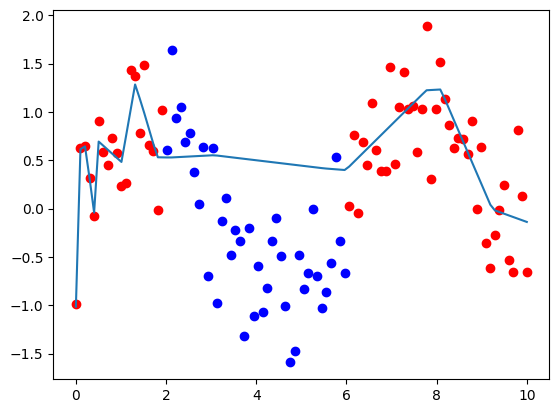

In [23]:
plt.figure()
plt.scatter(x_training,y_training,c='red')
plt.scatter(x_test,y_test,c='blue')
plt.plot(x, logit_outputs)

We will now define an optimization step that differentiates with respect to a diversity term as well. What do we hope to get instead of the output in the above figure? We'd hope that the output is pushed both towards the positive part of the y axis as well as the negative part. The predictions will be made more ``uncertain" as the predictive values will be far away from the values predicted on the training set.

In [24]:
@jax.jit
def train_step_diverse(state, dropout_rng):
    """
    Trains the neural network for a single step."
    Parameters
    ----------
    state : train_state.TrainState
        The initial training state of the experiment.
    batch : dict
        Dictionary with keys 'image' and 'label' corresponding to a batch of the training set.
    dropout_rng : jax.random.PRNGKey
        Pseudo-random number generator (PRNG) key for the randomness of the dropout layers.

    Returns
    -------
    state : train_state.TrainState
        The training state of the experiment.
    metrics : dict
        A python dictionary with keys "loss" and "accuracy" corresponding to the cross-entropy loss and the accuracy
        for some logits and labels.
    new_dropout_rng : jax.random.PRNGKey
        New pseudo-random number generator (PRNG) key for the randomness of the dropout layers.

    """
    dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

    def loss_fn(params):
        logits = state.apply_fn(params, x_training, train=True, rngs={'dropout': dropout_rng})
        loss = squared_error(logits=logits, targets=y_training)
        return loss, logits

    def output_logits_training(params):
        logits = state.apply_fn(params, x_training, train=True, rngs={'dropout': dropout_rng})
        logits_sum = jnp.sum(logits)
        return logits_sum

    def output_logits_unlabeled(params):
        logits = state.apply_fn(params, x_unlabeled, train=True, rngs={'dropout': dropout_rng})
        logits_sum = jnp.sum(logits)
        return logits_sum

    grad_fn = jax.grad(loss_fn, has_aux=True)
    output_training_grad_fn = jax.grad(output_logits_training, has_aux=False)
    output_unlabeled_grad_fn = jax.grad(output_logits_unlabeled, has_aux=False)

    grads, logits = grad_fn(state.params)
    grads_diverse_training = output_training_grad_fn(state.params)
    grads_diverse_unlabeled = output_unlabeled_grad_fn(state.params)

    def diverse_term(grads_diverse_training, grads_diverse_unlabeled, mylambda, prior_var):

        term1 = jax.tree_map(lambda x: (mylambda*x**2+1/prior_var)**(-2)*(2*mylambda*x**3), grads_diverse_training)
        term2 = jax.tree_map(lambda x: x**2, grads_diverse_unlabeled)
        term3 = jax.tree_map(lambda x: (mylambda*x**2+1/prior_var)**(-1), grads_diverse_training)
        term4 = jax.tree_map(lambda x: 2*x**3, grads_diverse_unlabeled)

        return jax.tree_map(lambda x, y, z, k: x*y+z*k, term1, term2, term3, term4)

    mylambda = 0.0001
    prior_var = 0.0001
    beta = 0.0001

    divers_grads = jax.tree_map(lambda x: x*beta,diverse_term(grads_diverse_training, grads_diverse_unlabeled, mylambda, prior_var))

    grads_total = jax.tree_map(lambda x, y: x+y, grads, divers_grads)

    #print(divers_grads['params']['Dense_1']['kernel'])
    #print(grads['params']['Dense_1']['kernel'])

    state = state.apply_gradients(grads=grads_total)
    metrics = compute_metrics(logits=logits, targets=y_training)
    return state, metrics, new_dropout_rng

def train_network_diverse():
    """

    Parameters
    ----------
    cfg : DictConfig
        The configuration file for the experiment.
    Returns
    -------
    test_accuracy : float
        The final test accuracy of the trained model. This is useful when doing hyperparameter search with optuna.

    """

    rng = jax.random.PRNGKey(40)#0
    rng, init_rng = jax.random.split(rng)

    state = create_train_state(init_rng)
    del init_rng #Must not be used anymore

    num_epochs = 5000

    test_log_dir = 'logs/diverse_training/test'
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    for epoch in range(1,num_epochs+1):
        # Use a separate PRNG key to permute image data during shuffling
        rng, input_rng = jax.random.split(rng)
        # Run an optimization step over a training batch
        state = train_epoch_diverse(state, epoch, input_rng)
        # Evaluate on the test set after each training epoch
        test_loss = eval_model(state)
        print('test epoch: %d, loss: %.2f' % (epoch, test_loss))

        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss, step=epoch)

    return test_loss, state

def train_epoch_diverse(state, epoch, rng):
    """
    Train for a single epoch.
    Parameters
    ----------
    state : train_state.TrainState
        The training state of the experiment.
    train_ds: dict
        Dictionary with keys 'image' and 'label' corresponding to the training set.
    batch_size : int
        The size of the batch.
    epoch : int
        The number of the current epoch.
    rng : jax.random.PRNGKey
        Pseudo-random number generator (PRNG) key for the random initialization of the neural network.

    Returns
    -------
    state : train_state.TrainState
        The new training state of the experiment.

    """

    batch_metrics = []
    dropout_rng = jax.random.split(rng, jax.local_device_count())[0]

    state, metrics, dropout_rng = train_step_diverse(state, dropout_rng)
    batch_metrics.append(metrics)

    #compute mean of metrics across each batch in epoch.train_state
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0] # jnp.mean does not work on lists
    }

    print('train epoch: %d, loss %.4f' % (epoch, epoch_metrics_np['loss']))

    train_log_dir = 'logs/diverse_training/training'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    with train_summary_writer.as_default():
        tf.summary.scalar('l2_error', epoch_metrics_np['loss'], step=epoch)

    return state

Let's now train the network with the diverse loss.

In [25]:
test_loss_diverse, final_state_diverse = train_network_diverse()

train epoch: 1, loss 1.3165
test epoch: 1, loss: 0.73
train epoch: 2, loss 0.3693
test epoch: 2, loss: 1.20
train epoch: 3, loss 0.8990
test epoch: 3, loss: 0.93
train epoch: 4, loss 0.5679
test epoch: 4, loss: 0.53
train epoch: 5, loss 0.2438
test epoch: 5, loss: 0.30
train epoch: 6, loss 0.3523
test epoch: 6, loss: 0.25
train epoch: 7, loss 0.5533
test epoch: 7, loss: 0.25
train epoch: 8, loss 0.5233
test epoch: 8, loss: 0.31
train epoch: 9, loss 0.3397
test epoch: 9, loss: 0.44
train epoch: 10, loss 0.2312
test epoch: 10, loss: 0.62
train epoch: 11, loss 0.2801
test epoch: 11, loss: 0.75
train epoch: 12, loss 0.3731
test epoch: 12, loss: 0.75
train epoch: 13, loss 0.3772
test epoch: 13, loss: 0.65
train epoch: 14, loss 0.2972
test epoch: 14, loss: 0.51
train epoch: 15, loss 0.2315
test epoch: 15, loss: 0.39
train epoch: 16, loss 0.2440
test epoch: 16, loss: 0.33
train epoch: 17, loss 0.3029
test epoch: 17, loss: 0.31
train epoch: 18, loss 0.3314
test epoch: 18, loss: 0.33
train epoc

Let's plot now the output of the neural network.

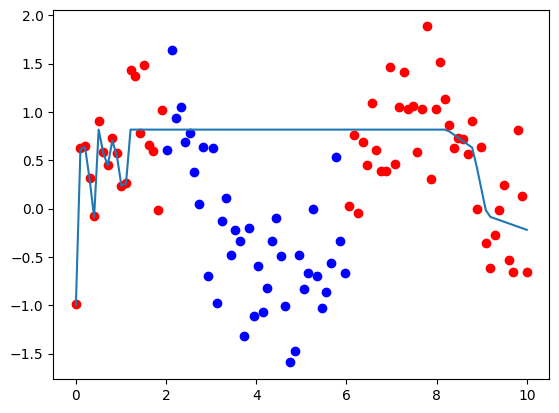

In [26]:
logit_outputs = evaluate_model_outputs(state = final_state_diverse, input = jnp.expand_dims(x,axis=1))
plt.figure()
plt.scatter(x_training,y_training,c='red')
plt.scatter(x_test,y_test,c='blue')
plt.plot(x, logit_outputs)